# **Линейные модели, SVM и деревья решений.**

**Цель лабораторной работы**: изучение линейных моделей, SVM и деревьев решений.\
**Задание:**
- Выберите набор данных (датасет) для решения задачи классификации или регрессии.
- В случае необходимости проведите удаление или заполнение пропусков и кодирование категориальных признаков.
- С использованием метода train_test_split разделите выборку на обучающую и тестовую.
- Обучите следующие модели:
 - одну из линейных моделей (линейную или полиномиальную регрессию при решении задачи регрессии, логистическую регрессию при решении задачи классификации);
 - SVM;
 - дерево решений.
- Оцените качество моделей с помощью двух подходящих для задачи метрик. Сравните качество полученных моделей.
- Постройте график, показывающий важность признаков в дереве решений.
- Визуализируйте дерево решений или выведите правила дерева решений в текстовом виде.

### **Импорт библиотек и загрузка датасета**
Импортируем библиотеки с помощью команды import.

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set(style="ticks")
from sklearn.model_selection import train_test_split
from operator import itemgetter
import matplotlib.ticker as ticker
import math
from enum import Enum
from sklearn.impute import SimpleImputer
from sklearn.impute import MissingIndicator
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from typing import Dict, Tuple
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, fbeta_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import KFold, RepeatedKFold, LeaveOneOut, LeavePOut, ShuffleSplit, StratifiedKFold, StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, NuSVC, LinearSVC, OneClassSVM, SVR, NuSVR, LinearSVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz
import pydotplus

In [4]:
filename = '../datasets/water_potability.csv'
data = pd.read_csv(filename)

### **Очистка датасета**

Основываясь на том, что мы делали выше, обработаем все остальные столбцы и таким образом полностью почистим набор

In [5]:
data.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000,3276.000000
mean,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,0.390110
std,1.594320,32.879761,8768.570828,1.583085,41.416840,80.824064,3.308162,16.175008,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.093092,176.850538,15666.690297,6.127421,307.699498,365.734414,12.065801,55.844536,3.439711,0.000000
50%,7.036752,196.967627,20927.833607,7.130299,333.073546,421.884968,14.218338,66.622485,3.955028,0.000000
75%,8.062066,216.667456,27332.762127,8.114887,359.950170,481.792304,16.557652,77.337473,4.500320,1.000000
max,14.000000,323.124000,61227.196008,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


In [6]:
data.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [7]:
# проверим пропущенные значения
data.isnull().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

In [8]:
strategies=['mean', 'median', 'most_frequent']

In [9]:
# импьютация нужной колонки с помощью нужной стратегии
def func_impute_col(dataset, column, strategy_param):
    temp_data = dataset[[column]]
    
    imp_num = SimpleImputer(strategy=strategy_param)
    data_num_imp = imp_num.fit_transform(temp_data)
    
    return data_num_imp

In [10]:
# замена медианой pH
col_imp = func_impute_col(data, 'ph', strategies[1])
data[['ph']] = col_imp

In [11]:
# замена медианой Sulfate
col_imp = func_impute_col(data, 'Sulfate', strategies[1])
data[['Sulfate']] = col_imp

In [12]:
# замена медианой Sulfate
col_imp = func_impute_col(data, 'Trihalomethanes', strategies[1])
data[['Trihalomethanes']] = col_imp

In [13]:
# проверим пропущенные значения
data.isnull().sum()

ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64

### **Разделение выборки на обучающую и тестовую**

In [14]:
# целевой признак - Potability - указывает, безопасна ли вода для потребления человеком 
target = data['Potability']

In [15]:
data.corr()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
ph,1.000000,0.075760,-0.082004,-0.031741,0.014178,0.017466,0.040240,0.003145,-0.036107,-0.003014
Hardness,0.075760,1.000000,-0.046899,-0.030054,-0.092833,-0.023915,0.003610,-0.012707,-0.014449,-0.013837
Solids,-0.082004,-0.046899,1.000000,-0.070148,-0.149747,0.013831,0.010242,-0.008799,0.019546,0.033743
Chloramines,-0.031741,-0.030054,-0.070148,1.000000,0.023762,-0.020486,-0.012653,0.016614,0.002363,0.023779
Sulfate,0.014178,-0.092833,-0.149747,0.023762,1.000000,-0.014182,0.027102,-0.025657,-0.009767,-0.020476
Conductivity,0.017466,-0.023915,0.013831,-0.020486,-0.014182,1.000000,0.020966,0.001184,0.005798,-0.008128
Organic_carbon,0.040240,0.003610,0.010242,-0.012653,0.027102,0.020966,1.000000,-0.012958,-0.027308,-0.030001
Trihalomethanes,0.003145,-0.012707,-0.008799,0.016614,-0.025657,0.001184,-0.012958,1.000000,-0.021487,0.006887
Turbidity,-0.036107,-0.014449,0.019546,0.002363,-0.009767,0.005798,-0.027308,-0.021487,1.000000,0.001581
Potability,-0.003014,-0.013837,0.033743,0.023779,-0.020476,-0.008128,-0.030001,0.006887,0.001581,1.000000


In [16]:
# уберем столбцы, слабо коррелирующие с целевым признаком
data_clean = data
data_clean = data_clean.drop(columns = ['ph'], axis = 1)
data_clean = data_clean.drop(columns = ['Conductivity'], axis = 1)
data_clean = data_clean.drop(columns = ['Trihalomethanes'], axis = 1)
data_clean = data_clean.drop(columns = ['Turbidity'], axis = 1)
data_clean = data_clean.drop(columns = ['Hardness'], axis = 1)
data_clean2 = data_clean.drop(columns = ['Potability'], axis = 1)

In [17]:
x_train,x_test,y_train,y_test=train_test_split(data_clean2,target,test_size=0.2,random_state=1)

In [18]:
data_clean2_np = data_clean2.to_numpy()
target_np = target.to_numpy()

In [19]:
data_clean2.corr()

,Solids,Chloramines,Sulfate,Organic_carbon
Solids,1.000000,-0.070148,-0.149747,0.010242
Chloramines,-0.070148,1.000000,0.023762,-0.012653
Sulfate,-0.149747,0.023762,1.000000,0.027102
Organic_carbon,0.010242,-0.012653,0.027102,1.000000


In [20]:
feature_names = ['Solids', 'Chloramines', 'Sulfate', 'Organic_carbon']

## **Обучение моделей**

### **Логистическая регрессия**

Воспользуемся методом логистической регрессии для решения имеющейся у нас задачи бинарной классификации

Метод основан на использовании логистической кривой или сигмоиды. \
Сигмо́ида — это гладкая монотонная возрастающая нелинейная функция, имеющая форму буквы «S», которая часто применяется для «сглаживания» значений некоторой величины.

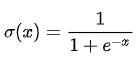

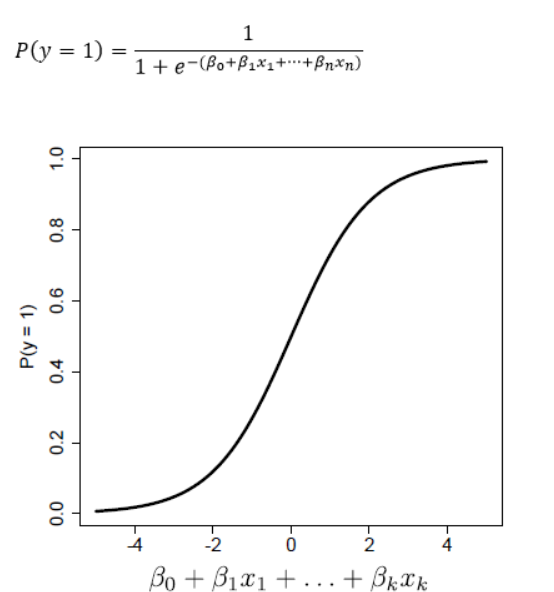

In [21]:
logistic_model = LogisticRegression()
logistic_model.fit(x_train, y_train)

LogisticRegression()

In [22]:
y_test_predict = logistic_model.predict(x_test)
y_test_predict

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [23]:
y_test_predict_proba = logistic_model.predict_proba(x_test)
y_test_predict_proba[:10]

array([[0.61652376, 0.38347624],
       [0.60773966, 0.39226034],
       [0.59107705, 0.40892295],
       [0.57013794, 0.42986206],
       [0.59115343, 0.40884657],
       [0.60203948, 0.39796052],
       [0.57433869, 0.42566131],
       [0.58619166, 0.41380834],
       [0.61403854, 0.38596146],
       [0.59616169, 0.40383831]])

In [24]:
# Вероятности принадлежности к 0 классу
[round(x, 4) for x in y_test_predict_proba[:10,0]]

[0.6165, 0.6077, 0.5911, 0.5701, 0.5912, 0.602, 0.5743, 0.5862, 0.614, 0.5962]

In [25]:
# Вероятности принадлежности к 1 классу
[round(x, 4) for x in y_test_predict_proba[:10,1]]

[0.3835, 0.3923, 0.4089, 0.4299, 0.4088, 0.398, 0.4257, 0.4138, 0.386, 0.4038]

In [26]:
def accuracy_score_for_classes(
    y_true: np.ndarray, 
    y_pred: np.ndarray) -> Dict[int, float]:
    """
    Вычисление метрики accuracy для каждого класса
    y_true - истинные значения классов
    y_pred - предсказанные значения классов
    Возвращает словарь: ключ - метка класса, 
    значение - Accuracy для данного класса
    """
    # Для удобства фильтрации сформируем Pandas DataFrame 
    d = {'t': y_true, 'p': y_pred}
    df = pd.DataFrame(data=d)
    # Метки классов
    classes = np.unique(y_true)
    # Результирующий словарь
    res = dict()
    # Перебор меток классов
    for c in classes:
        # отфильтруем данные, которые соответствуют 
        # текущей метке класса в истинных значениях
        temp_data_flt = df[df['t']==c]
        # расчет accuracy для заданной метки класса
        temp_acc = accuracy_score(
            temp_data_flt['t'].values, 
            temp_data_flt['p'].values)
        # сохранение результата в словарь
        res[c] = temp_acc
    return res

def print_accuracy_score_for_classes(
    y_true: np.ndarray, 
    y_pred: np.ndarray):
    """
    Вывод метрики accuracy для каждого класса
    """
    accs = accuracy_score_for_classes(y_true, y_pred)
    if len(accs)>0:
        print('Метка \t Accuracy')
    for i in accs:
        print('{} \t {}'.format(i, accs[i]))

In [27]:
accuracy_score(y_test, y_test_predict)

0.5701219512195121

In [28]:
print_accuracy_score_for_classes(y_test, y_test_predict)

Метка 	 Accuracy
0 	 1.0
1 	 0.0035335689045936395


In [29]:
y_test_predict = logistic_model.predict(x_test)

In [30]:
def class_proportions(array: np.ndarray) -> Dict[int, Tuple[int, float]]:
    """
    Вычисляет пропорции классов
    array - массив, содержащий метки классов
    """
    # Получение меток классов и количества меток каждого класса 
    labels, counts = np.unique(array, return_counts=True)
    # Превращаем количество меток в процент их встречаемости
    # делим количество меток каждого класса на общее количество меток
    counts_perc = counts/array.size
    # Теперь sum(counts_perc)==1.0
    # Создаем результирующий словарь,
    # ключом словаря явлется метка класса, 
    # а значением словаря процент встречаемости метки
    res = dict()
    for label, count2 in zip(labels, zip(counts, counts_perc)):
        res[label] = count2
    return res

def print_class_proportions(array: np.ndarray):
    """
    Вывод пропорций классов
    """
    proportions = class_proportions(array)
    if len(proportions)>0:
        print('Метка \t Количество \t Процент встречаемости')
    for i in proportions:
        val, val_perc = proportions[i]
        val_perc_100 = round(val_perc * 100, 2)
        print('{} \t {} \t \t {}%'.format(i, val, val_perc_100))

In [31]:
print_class_proportions(y_test)

Метка 	 Количество 	 Процент встречаемости
0 	 373 	 	 56.86%
1 	 283 	 	 43.14%


### **Метод опорных векторов (SVM)**

Основная идея метода — перевод исходных векторов в пространство более высокой размерности и поиск разделяющей гиперплоскости с максимальным зазором в этом пространстве. Две параллельных гиперплоскости строятся по обеим сторонам гиперплоскости, разделяющей классы. Разделяющей гиперплоскостью будет гиперплоскость, максимизирующая расстояние до двух параллельных гиперплоскостей. Алгоритм работает в предположении, что чем больше разница или расстояние между этими параллельными гиперплоскостями, тем меньше будет средняя ошибка классификатора.

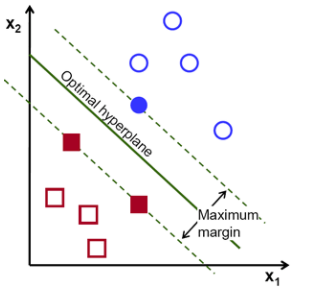

- На этапе обучения (fit) по точкам (векторам) обучающей выборки строится уравнение оптимальной разделяющей гиперплоскости. Это сложная задача, которая решается с применением методов оптимизации.
- На этапе предсказания (predict) точка тестовой выборки подставляется в полученное уравнение и определяется класс, к которому принадлежит точка.

In [32]:
x_train_np = np.array(x_train)
y_train_np = np.array(y_train)
x_test_np = np.array(x_test)
y_test_np = np.array(y_test)

In [33]:
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(x_train_np, y_train_np)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])

In [34]:
svm_predict = (clf.predict(x_test))

c:\Users\Pocht\OneDrive\Study\6 семестр\ТМО (Гапанюк)\ML-Technologies\env\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [35]:
accuracy_score(y_test, svm_predict)

0.6036585365853658

## **Деревья решений**

**Основной алгоритм построения дерева решения** \
Фактически, алгоритм построения обучающего дерева, детально описанный здесь, сводится к нескольким пунктам:

1. Для текущего выбранного признака (колонки) из N признаков построить все варианты ветвления (разбиения) по значениям (для категориальных признаков) или по диапазонам значений (для числовых признаков). При этом будет сформировано K поддеревьев (где K - число ветвлений). Каждое поддерево содержит подвыборку, которая включает только строки выборки, соответствующие результатам ветвления. В каждом поддереве расположена:

  - или выборка, содержащая N-1 признак, если признак, для которого строится ветвление, полностью пропадает в результате ветвления;
  - или выборка, содержащая N признаков, если признак, для которого строится ветвление, не пропадает полностью в результате ветвления, но при этом число строк в выборке уменьшается;
2. Если подвыборке соответствует единственное значение целевого признака, то в дерево добавляется терминальный лист, который соответствует предсказанному значению.

3. Если в подвыборке больше одного значения целевого признака, то предыдущие пункты выполняются рекурсивно для подвыборки.

In [36]:
# Обучим дерево на всех признаках
tree_cl = DecisionTreeClassifier(random_state=1)
tree_cl.fit(x_train, y_train)

DecisionTreeClassifier(random_state=1)

In [37]:
cross_val_score(clf, x_train, y_train, cv=10)

array([0.65267176, 0.62977099, 0.65648855, 0.63358779, 0.64122137,
       0.63358779, 0.60305344, 0.63740458, 0.64885496, 0.65648855])

In [38]:
tree_predict = tree_cl.predict(x_test)

In [39]:
accuracy_score(y_test, tree_predict)

0.5213414634146342

### **Визуализация дерева**

In [ ]:
dot_data = export_graphviz(tree_cl, out_file=None, 
                           feature_names=feature_names, 
                           class_names=['is_safe', 'not_safe'], 
                           filled=True, rounded=True, special_characters=True)  
graph = graphviz.Source(dot_data)  
# dt_graphviz = tree.export_graphviz(dt, out_file = None)
# graph = pydotplus.graph_from_dot_data(dt_graphviz)
graph

### **Важность признаков в дереве решений**

С помощью свойства feature/importances можно получить значение важности признаков. \
Вычисление важности признаков основано на том, какое количество раз признак встречается в условиях дерева. Чем чаще встречается признак, тем более он важен.

In [ ]:
# Важность признаков
list(zip(feature_names, tree_cl.feature_importances_))

[('Solids', 0.23653143475779084),
 ('Chloramines', 0.2808887164371071),
 ('Sulfate', 0.22622293125018245),
 ('Organic_carbon', 0.25635691755491957)]

In [ ]:
from operator import itemgetter

def draw_feature_importances(tree_model, X_dataset, figsize=(18,5)):
    """
    Вывод важности признаков в виде графика
    """
    # Сортировка значений важности признаков по убыванию
    list_to_sort = list(zip(X_dataset.columns.values, tree_model.feature_importances_))
    sorted_list = sorted(list_to_sort, key=itemgetter(1), reverse = True)
    # Названия признаков
    labels = [x for x,_ in sorted_list]
    # Важности признаков
    data = [x for _,x in sorted_list]
    # Вывод графика
    fig, ax = plt.subplots(figsize=figsize)
    ind = np.arange(len(labels))
    plt.bar(ind, data)
    plt.xticks(ind, labels, rotation='vertical')
    # Вывод значений
    for a,b in zip(ind, data):
        plt.text(a-0.05, b+0.01, str(round(b,3)))
    plt.show()
    return labels, data

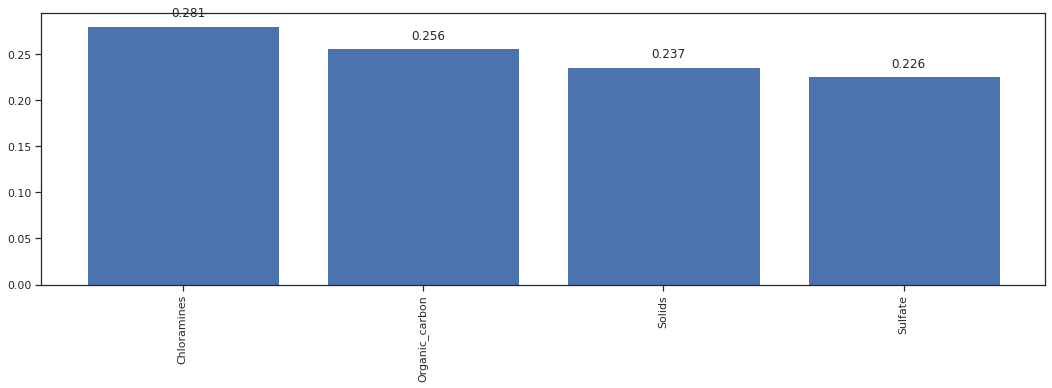

In [ ]:
labels, data = draw_feature_importances(tree_cl, x_train)